In [61]:
%pylab inline
%matplotlib inline

# Global Imports
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
from sklearn import datasets
import os
import sys
import pickle
from pprint import pprint
from time import time
import datetime
from time import gmtime, strftime
import statsmodels.api as sm
from patsy import dmatrices

# Scikit-Learn imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import cross_val_score
from sklearn import metrics

# Local Imports
path = str(os.path.expanduser('~')) + '/git/predictEPL/config'
sys.path.append(path)
import paths

sys.path.append(paths.UTILS)
import useful_methods

Populating the interactive namespace from numpy and matplotlib


## Data Manipulation Functions

In [2]:
def ReadHashDf():
    # Read game_infos as df
    dfGameInfo = useful_methods.csv_dic_df(paths.READ_PATH_GAME_INFO + 'game_infos.csv')
    dfGameInfo = useful_methods.DropNanGames(dfGameInfo).copy().reset_index(drop=True)
    dfGameInfo.GW = [int(gw) for gw in dfGameInfo.GW]
    dfGameInfo = dfGameInfo.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)

    # Read Hash Emolex Model result
    df = useful_methods.csv_dic_df(paths.READ_PATH_RESULTS + RESULT_FILE_NAME)
    df.GW = [int(gw) for gw in df.GW]
    df = df.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)


    # Combine 2 dfs
    df['score_ht_away'] = [int(item) for item in dfGameInfo.score_ht_away]
    df['score_ht_home'] = [int(item) for item in dfGameInfo.score_ht_home]
    df['score_ft_away'] = [int(item) for item in dfGameInfo.score_ft_away]
    df['score_ft_home'] = [int(item) for item in dfGameInfo.score_ft_home]

    df['pn_away_neg'] = [float(item) for item in df.pn_away_neg]
    df['pn_away_pos'] = [float(item) for item in df.pn_away_pos]
    df['pn_home_neg'] = [float(item) for item in df.pn_home_neg]
    df['pn_home_pos'] = [float(item) for item in df.pn_home_pos]

    # ******************************************************
    # 'home_win': 1, 'away_win': 0, 'draw': 2
    def Labeling3(goal_diff):
        if goal_diff > 0:
            return 1
        elif goal_diff < 0:
            return 0
        else:
            return 2

    df['goal_diff_ht'] = df.score_ht_home - df.score_ht_away
    df['goal_diff_ft'] = df.score_ft_home - df.score_ft_away
    df['result'] = [Labeling3(item) for item in df.goal_diff_ft]
    
    
    # 'home_win, draw': 1, 'home_lose': 0
    def Labeling2(goal_diff):
        if goal_diff < 0:
            return 0
        else:
            return 1
    df['res2'] = [Labeling2(item) for item in df.goal_diff_ft]

    # **********************************************
    # Add previous 4 games points sum
    dfBe4GameSum = useful_methods.csv_dic_df(paths.DATA_HOME + "EPL/info_before_4game_sum.csv")

    team_homes = list(df.home_team)
    team_aways = list(df.away_team)
    GWs = [int(gw) for gw in df.GW]

    be_4game_sum_home = []
    be_4game_sum_away = []

    for index in range(len(GWs)):
        team_home = team_homes[index]
        team_away = team_aways[index]
        gw = GWs[index]

        be_4game_sum_home.append(int(dfBe4GameSum[dfBe4GameSum.team == team_home][str(gw)]))
        be_4game_sum_away.append(int(dfBe4GameSum[dfBe4GameSum.team == team_away][str(gw)]))

    df['be_4game_sum_away'] = be_4game_sum_away
    df['be_4game_sum_home'] = be_4game_sum_home    

    return df

In [3]:
# Create df for models.
def CreateDfForModel(ht_draw=False, ft_wld=False):
    df = ReadHashDf()
        
    # only for Win or Lose
    if not ft_wld:
        df = df[df.result != 2].copy().reset_index(drop=True)
    
    # HT: Equal
    if ht_draw:
        df = df[df.goal_diff_ht == 0].copy().reset_index(drop=True)
    
    dta = pd.DataFrame()
    
    # Teams
    dta['team_home'] = df.home_team
    dta['team_away'] = df.away_team

    # POS, NEG scores by percentage %
    dta['pn_home_pos'] = df.pn_home_pos / (df.pn_home_pos + df.pn_home_neg)
    dta['pn_home_neg'] = df.pn_home_neg / (df.pn_home_pos + df.pn_home_neg)
    dta['pn_away_pos'] = df.pn_away_pos / (df.pn_away_pos + df.pn_away_neg)
    dta['pn_away_neg'] = df.pn_away_neg / (df.pn_away_pos + df.pn_away_neg)
    
    dta['pn_diff_pos'] = dta['pn_home_pos'] - dta['pn_away_pos']
    dta['pn_diff_neg'] = dta['pn_home_neg'] - dta['pn_away_neg']
    
    # HF scores
    dta['score_ht_home'] = df.score_ht_home
    dta['score_ht_away'] = df.score_ht_away
    dta['score_ft_home'] = df.score_ft_home
    dta['score_ft_away'] = df.score_ft_away
    
    dta['goal_diff_ht'] = df['goal_diff_ht']
    dta['goal_diff_ft'] = df['goal_diff_ft']

    # 'home_win': 1, 'away_win': 0, 'draw': 2
    dta['result'] = df.result
    
    # 'home_win or draw': 1, 'home_lose': 0
    dta['res2'] = df['res2']
    
    # be_4game_sum
    dta['be_4game_sum_home'] = df.be_4game_sum_home / 12.0
    dta['be_4game_sum_away'] = df.be_4game_sum_away / 12.0
    
    # ht_point * sentiments
    dta['sp_home'] = dta['pn_home_pos'] * (dta['score_ht_home'] + 1)
    dta['sn_home'] = dta['pn_home_neg'] * (dta['score_ht_home'] + 1)
    dta['sp_away'] = dta['pn_away_pos'] * (dta['score_ht_away'] + 1)
    dta['sn_away'] = dta['pn_away_neg'] * (dta['score_ht_away'] + 1)
    dta['sp_diff'] = dta['sp_home'] - dta['sp_away']
    dta['sn_diff'] = dta['sn_home'] - dta['sn_away']
    
    return dta

In [4]:
# X: df, y: list
def CreateXy(df, team_name=False, hash_emolex=True, score_ht=True, be_4game_sum=False, score_sent=False):
    print("--------------------------\n")
#     print("score_ht: %s, be_4game_sum: %s\nhash_emolex: %s,  team_name: %s\n" %
#           (score_ht, be_4game_sum, hash_emolex, team_name))
    
    if team_name and hash_emolex and score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            score_ht_home + score_ht_away + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + \
            pn_diff_pos + \
            C(team_home) + C(team_away)',
            df, return_type="dataframe")
    elif hash_emolex and score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            score_ht_home + score_ht_away + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + \
            pn_diff_pos',
            df, return_type="dataframe")
    elif hash_emolex and be_4game_sum:
        y, X = dmatrices('result ~ \
            be_4game_sum_home + be_4game_sum_away + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + \
            pn_diff_pos',
            df, return_type="dataframe")
    elif score_ht and be_4game_sum:
        y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away + \
            be_4game_sum_home + be_4game_sum_away',
            df, return_type="dataframe")
    elif score_ht and hash_emolex:
        y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg',
            df, return_type="dataframe")
    elif hash_emolex:
        y, X = dmatrices('result ~ \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg',
            df, return_type="dataframe")
    elif score_sent:
        y, X = dmatrices('result ~ \
            sp_home + sn_home + sp_away + sn_away',
            df, return_type="dataframe")
    else:
        y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away',
            df, return_type="dataframe")
        
    # flatten y into a 1-D array
    y = np.ravel(y)
    
    return X, y

## Models: Logistic, SVC

In [10]:
def ModelScoresWL(df, team_name, hash_emolex, score_ht, be_4game_sum, variable_scores=False, score_sent=False):
    # instantiate a logistic regression model, and fit with X and y
    X, y = CreateXy(df, team_name, hash_emolex, score_ht, be_4game_sum, score_sent)

    # Set Models
    model_log = LogisticRegression(penalty='l1')
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(LogisticRegression(penalty='l1'), X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(SVC(), X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))
    
    
    if variable_scores:
        # Variable Scores
        dfVars = pd.DataFrame()
        dfVars['var'] = X.columns
        dfVars['score'] = np.transpose(model_log.coef_)
        print("\n", dfVars)

In [11]:
def ModelScoresWLD(df, team_name, hash_emolex, score_ht, be_4game_sum, score_sent=False):
    # instantiate a logistic regression model, and fit with X and y
    X, y = CreateXy(df, team_name, hash_emolex, score_ht, be_4game_sum, score_sent)

    # Set Models
    model_log = LogisticRegression(penalty='l1')
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(LogisticRegression(penalty='l1'), X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(SVC(), X, y, scoring='accuracy', cv=18)

    # Accuracy scores
#     print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))

### Accuracy

In [7]:
# Definings
RESULT_FILE_NAME = "hash_all_ht.csv"

In [8]:
# Create DFs for models
# WL: win, lose; WLD: win, lose, draw
dfWL = CreateDfForModel(ht_draw=False, ft_wld=False)
dfWLD = CreateDfForModel(ht_draw=False, ft_wld=True)

In [12]:
# Win, Lose
ModelScoresWL(dfWL, team_name=False, hash_emolex=False, score_ht=True, be_4game_sum=False, variable_scores=True)
ModelScoresWL(dfWL, team_name=False, hash_emolex=False, score_ht=True, be_4game_sum=True, variable_scores=True)
ModelScoresWL(dfWL, team_name=False, hash_emolex=True, score_ht=False, be_4game_sum=False, variable_scores=True)
# ModelScoresWL(dfWL, team_name=False, hash_emolex=True, score_ht=False, be_4game_sum=True, variable_scores=False)
ModelScoresWL(dfWL, team_name=False, hash_emolex=True, score_ht=True, be_4game_sum=False, variable_scores=True)
# ModelScoresWL(dfWL, team_name=True, hash_emolex=True, score_ht=True, be_4game_sum=True, variable_scores=False)

ModelScoresWL(dfWL, team_name=False, hash_emolex=False, score_ht=False, be_4game_sum=False,
              variable_scores=True, score_sent=True)

--------------------------

[Log]: 	0.766 (cv: 0.744)
[SVC]: 	0.766 (cv: 0.765)

              var     score
0      Intercept  0.023792
1  score_ht_home  1.436069
2  score_ht_away -1.886118
--------------------------

[Log]: 	0.766 (cv: 0.744)
[SVC]: 	0.766 (cv: 0.765)

                  var     score
0          Intercept  0.149494
1      score_ht_home  1.435990
2      score_ht_away -1.886417
3  be_4game_sum_home  0.000000
4  be_4game_sum_away  0.000000
--------------------------

[Log]: 	0.664 (cv: 0.666)
[SVC]: 	0.594 (cv: 0.594)

            var     score
0    Intercept  0.000000
1  pn_home_pos  1.446616
2  pn_home_neg -1.224229
3  pn_away_pos -1.429445
4  pn_away_neg  1.867676
--------------------------

[Log]: 	0.766 (cv: 0.765)
[SVC]: 	0.766 (cv: 0.765)

              var     score
0      Intercept  0.000000
1  score_ht_home  1.407253
2  score_ht_away -1.882809
3    pn_home_pos  0.337066
4    pn_home_neg  0.000000
5    pn_away_pos  0.000000
6    pn_away_neg  0.006313
------------

In [13]:
ModelScoresWLD(dfWLD, team_name=False, hash_emolex=False, score_ht=True, be_4game_sum=False)
# ModelScoresWLD(dfWLD, team_name=False, hash_emolex=False, score_ht=True, be_4game_sum=True)
# ModelScoresWLD(dfWLD, team_name=False, hash_emolex=True, score_ht=False, be_4game_sum=False)
ModelScoresWLD(dfWLD, team_name=False, hash_emolex=True, score_ht=False, be_4game_sum=False)
# ModelScoresWLD(dfWLD, team_name=False, hash_emolex=True, score_ht=True, be_4game_sum=True)
# ModelScoresWLD(dfWLD, team_name=True, hash_emolex=True, score_ht=True, be_4game_sum=True)
ModelScoresWLD(dfWLD, team_name=False, hash_emolex=True, score_ht=True, be_4game_sum=False)
ModelScoresWLD(dfWLD, team_name=False, hash_emolex=False, score_ht=False, be_4game_sum=False, score_sent=True)

--------------------------

[Log]: 	0.554 (cv: 0.553)
[SVC]: 	0.582 (cv: 0.493)
--------------------------

[Log]: 	0.486 (cv: 0.487)
[SVC]: 	0.429 (cv: 0.431)
--------------------------

[Log]: 	0.554 (cv: 0.530)
[SVC]: 	0.593 (cv: 0.524)
--------------------------

[Log]: 	0.554 (cv: 0.537)
[SVC]: 	0.576 (cv: 0.507)


## Tune Variables

In [14]:
def ModelAccuracy(X, y, penalty='l2'):
    # Set Models
    model_log = LogisticRegression(penalty=penalty)
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(model_log, X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(model_svc, X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))


    # Variable Scores
    dfVars = pd.DataFrame()
    dfVars['var'] = X.columns
    dfVars['score'] = np.transpose(model_log.coef_)
    print("\n", dfVars)

In [239]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away + goal_diff_ht',
            df, return_type="dataframe")
y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.766 (cv: 0.728)
[SVC]: 	0.766 (cv: 0.765)

              var     score
0      Intercept  0.104290
1  score_ht_home  0.000000
2  score_ht_away -0.395758
3   goal_diff_ht  1.554483


In [40]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
#     'result ~ pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + pn_diff_pos + pn_diff_neg',
    'result ~ pn_away_neg + pn_diff_neg',
            df, return_type="dataframe")
y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.703 (cv: 0.697)
[SVC]: 	0.648 (cv: 0.641)

            var     score
0    Intercept  0.000000
1  pn_away_neg  0.499076
2  pn_diff_neg -4.102301


In [45]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
            score_ht_home + score_ht_away + goal_diff_ht + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + pn_diff_pos + pn_diff_neg',
            df, return_type="dataframe")
y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.766 (cv: 0.727)
[SVC]: 	0.766 (cv: 0.750)

              var     score
0      Intercept  0.000000
1  score_ht_home  0.000000
2  score_ht_away -0.412922
3   goal_diff_ht  1.500780
4    pn_home_pos  0.231529
5    pn_home_neg  0.000000
6    pn_away_pos  0.000000
7    pn_away_neg  0.000000
8    pn_diff_pos  0.382906
9    pn_diff_neg -0.000521


In [54]:
df = CreateDfForModel(ft_wld=False)
y, X = dmatrices(
    'result ~ \
            score_ht_home + score_ht_away + goal_diff_ht + \
            sp_home + sn_home + sp_away + sn_away + sp_diff + sn_diff + \
            pn_home_pos + pn_home_neg + pn_away_pos + pn_away_neg + pn_diff_pos + pn_diff_neg',
            df, return_type="dataframe")
y = np.ravel(y)

ModelAccuracy(X, y, penalty='l1')

--------------------------

[Log]: 	0.758 (cv: 0.752)
[SVC]: 	0.766 (cv: 0.743)

               var     score
0       Intercept  0.080096
1   score_ht_home  0.000000
2   score_ht_away -0.421583
3    goal_diff_ht  0.703015
4         sp_home  0.000000
5         sn_home  0.000000
6         sp_away  0.000000
7         sn_away  0.000000
8         sp_diff  1.284042
9         sn_diff  0.000000
10    pn_home_pos  0.000000
11    pn_home_neg  0.000000
12    pn_away_pos  0.000000
13    pn_away_neg  0.000000
14    pn_diff_pos  0.000000
15    pn_diff_neg  0.000000


## Scatter Plot

In [58]:
import numpy as np

pn_home_pos = np.array(df.pn_diff_pos)
score_ht_home = np.array(df.goal_diff_ht)

np.corrcoef(pn_home_pos, score_ht_home)

array([[ 1.        ,  0.51783162],
       [ 0.51783162,  1.        ]])

In [59]:
def PlotScatter(x, y):
    x = np.array(x)
    y = np.array(y)
    
    cm = plt.cm.get_cmap('seismic')
    z = x

    # Scatter Plot
    plt.figure(figsize=(10, 6))
    
    
    plt.yticks(np.arange(min(y) - 1, max(y) + 1, 1))
    
    sc = plt.scatter(x, y, c=z, marker="o", s=500, alpha=0.3, cmap=cm)
    plt.colorbar(sc)
    plt.grid(True)
    plt.axhline(y=0, c="k", alpha=0.5)
    plt.xlabel('Percentage')
    plt.ylabel('Result')
    plt.title('Sentiment Percentage against Result')
    plt.show()

    # Correlation
    print("Correlation: ", np.corrcoef(x, y)[0][1])

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


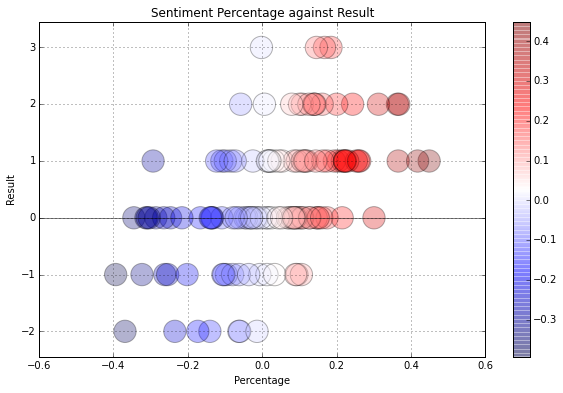

Correlation:  0.517831624877


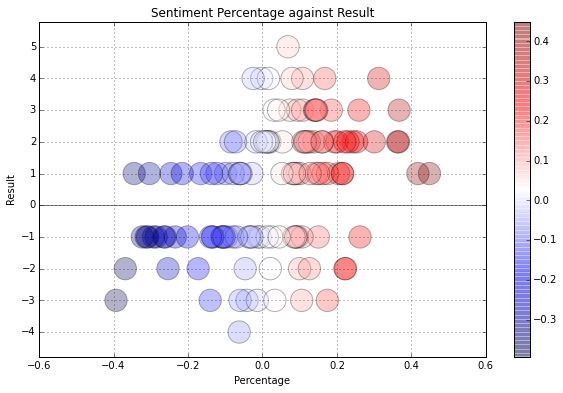

Correlation:  0.413103196416


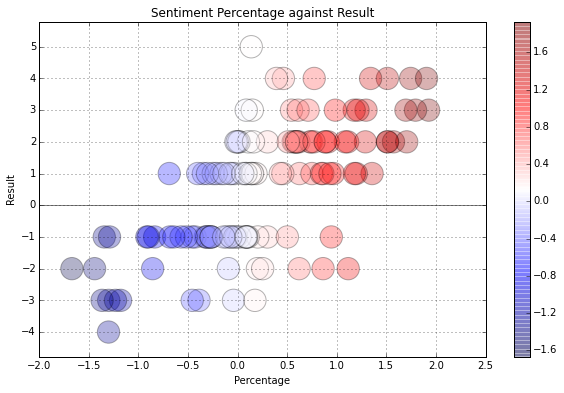

Correlation:  0.668726916726


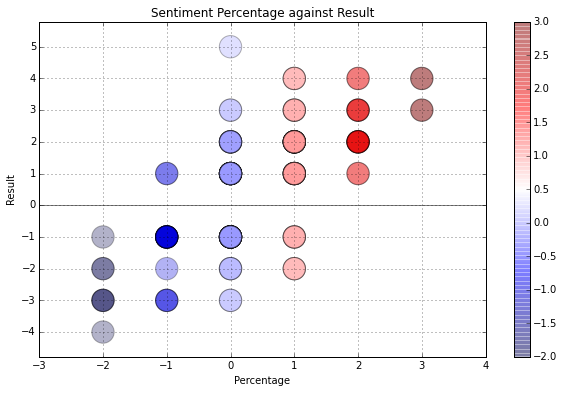

Correlation:  0.681701352606


In [60]:
df = CreateDfForModel(ft_wld=False)
PlotScatter(df.pn_diff_pos, df.goal_diff_ht)
PlotScatter(df.pn_diff_pos, df.goal_diff_ft)
PlotScatter(df.sp_diff, df.goal_diff_ft)
PlotScatter(df.goal_diff_ht, df.goal_diff_ft)

## Panda Dataframe Plot

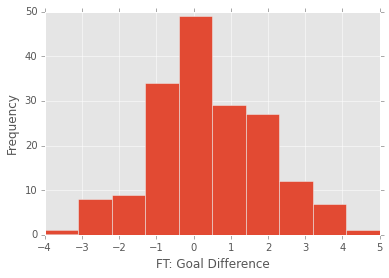

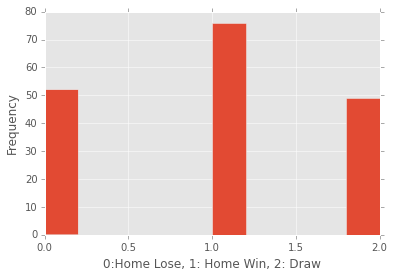

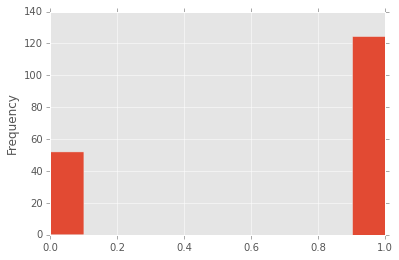

In [62]:
import matplotlib
matplotlib.style.use('ggplot')

df = CreateDfForModel(ft_wld=True)

# Plot Histogram
plt.figure()
df.goal_diff_ft.plot(kind='hist')
plt.xlabel("FT: Goal Difference")

plt.figure()
df.result.plot(kind='hist')
plt.xlabel("0:Home Lose, 1: Home Win, 2: Draw")

plt.figure()
df.res2.plot(kind='hist')

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


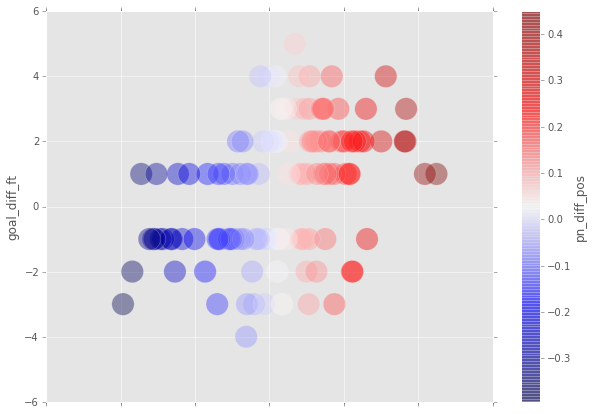

In [237]:
df = CreateDfForModel(ft_wld=False)
df.plot(kind='scatter',
        x='pn_diff_pos',
        y='goal_diff_ft',
        c='pn_diff_pos',
        marker="o",
        s=500,
        alpha=0.4,
        figsize=(10, 7),
        grid=True,
        colormap='seismic',
       )

In [66]:
# The correlation matrix 
cor = df.corr()
cor

,pn_home_pos,pn_home_neg,pn_away_pos,pn_away_neg,pn_diff_pos,pn_diff_neg,score_ht_home,score_ht_away,score_ft_home,score_ft_away,...,result,res2,be_4game_sum_home,be_4game_sum_away,sp_home,sn_home,sp_away,sn_away,sp_diff,sn_diff
pn_home_pos,1.000000,-1.000000,-0.122514,0.122514,0.743600,-0.743600,0.291229,-0.180317,0.198856,-0.148293,...,0.303984,0.303984,0.198989,0.031572,0.587963,-0.174408,-0.185530,-0.131791,0.531726,-0.068421
pn_home_neg,-1.000000,1.000000,0.122514,-0.122514,-0.743600,0.743600,-0.291229,0.180317,-0.198856,0.148293,...,-0.303984,-0.303984,-0.198989,-0.031572,-0.587963,0.174408,0.185530,0.131791,-0.531726,0.068421
pn_away_pos,-0.122514,0.122514,1.000000,-1.000000,-0.754689,0.754689,-0.337636,0.257971,-0.328645,0.251045,...,-0.334754,-0.334754,0.097169,0.263974,-0.315681,-0.292410,0.553041,-0.221482,-0.551478,-0.114331
pn_away_neg,0.122514,-0.122514,-1.000000,1.000000,0.754689,-0.754689,0.337636,-0.257971,0.328645,-0.251045,...,0.334754,0.334754,-0.097169,-0.263974,0.315681,0.292410,-0.553041,0.221482,0.551478,0.114331
pn_diff_pos,0.743600,-0.743600,-0.754689,0.754689,1.000000,-1.000000,0.419985,-0.292996,0.352864,-0.267160,...,0.426476,0.426476,0.066082,-0.156968,0.601354,0.081702,-0.495231,0.062090,0.723034,0.031794
pn_diff_neg,-0.743600,0.743600,0.754689,-0.754689,-1.000000,1.000000,-0.419985,0.292996,-0.352864,0.267160,...,-0.426476,-0.426476,-0.066082,0.156968,-0.601354,-0.081702,0.495231,-0.062090,-0.723034,-0.031794
score_ht_home,0.291229,-0.291229,-0.337636,0.337636,0.419985,-0.419985,1.000000,0.026769,0.703853,-0.036117,...,0.378645,0.378645,0.103616,-0.149472,0.931477,0.870780,-0.110407,0.216232,0.734728,0.663926
score_ht_away,-0.180317,0.180317,0.257971,-0.257971,-0.292996,0.292996,0.026769,1.000000,-0.044400,0.646472,...,-0.451313,-0.451313,0.035538,0.139777,-0.054841,0.131128,0.935550,0.863982,-0.588259,-0.506631
score_ft_home,0.198856,-0.198856,-0.328645,0.328645,0.352864,-0.352864,0.703853,-0.044400,1.000000,-0.142144,...,0.620853,0.620853,0.008040,-0.158942,0.638928,0.635465,-0.180223,0.159352,0.565268,0.483376
score_ft_away,-0.148293,0.148293,0.251045,-0.251045,-0.267160,0.267160,-0.036117,0.646472,-0.142144,1.000000,...,-0.716386,-0.716386,0.020156,0.220642,-0.103964,0.063589,0.621203,0.535165,-0.439187,-0.330455


In [70]:
cor.result

pn_home_pos          0.303984
pn_home_neg         -0.303984
pn_away_pos         -0.334754
pn_away_neg          0.334754
pn_diff_pos          0.426476
pn_diff_neg         -0.426476
score_ht_home        0.378645
score_ht_away       -0.451313
score_ft_home        0.620853
score_ft_away       -0.716386
goal_diff_ht         0.585144
goal_diff_ft         0.879732
result               1.000000
res2                 1.000000
be_4game_sum_home   -0.029193
be_4game_sum_away   -0.196605
sp_home              0.421707
sn_home              0.236453
sp_away             -0.498123
sn_away             -0.281726
sp_diff              0.595521
sn_diff              0.428672
Name: result, dtype: float64

## Scatter Matrix Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12672f9b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1272718d0>]], dtype=object)

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


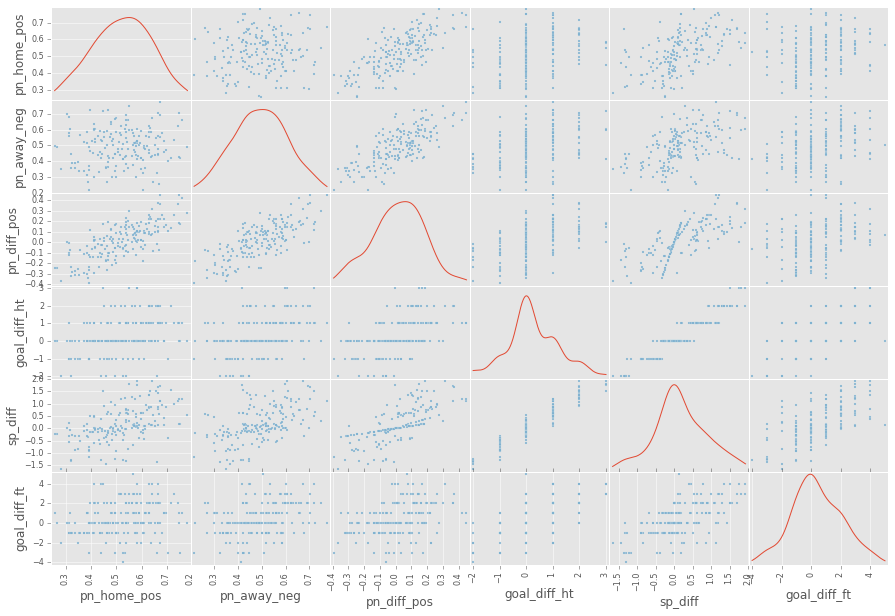

In [158]:
from pandas.tools.plotting import scatter_matrix

df = CreateDfForModel(ft_wld=True)
dta = df[[
        'pn_home_pos', 'pn_away_neg',
        'pn_diff_pos',
        'goal_diff_ht',
        'sp_diff',
        'goal_diff_ft']]

scatter_matrix(dta, alpha=0.8, figsize=(15, 10), diagonal='kde')

## Density Plot

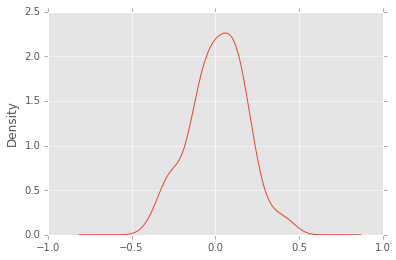

In [170]:
df = CreateDfForModel(ft_wld=True)

df.pn_diff_pos.plot(kind='kde')

## Andrews Curves

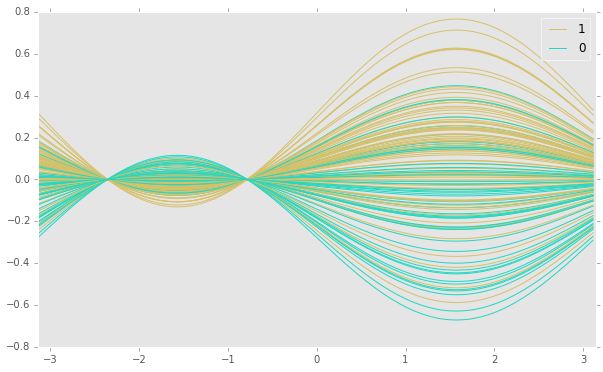

In [166]:
from pandas.tools.plotting import andrews_curves

df = CreateDfForModel(ft_wld=False)
data = df[['pn_diff_pos'] + ['result']]
# data = df[df.columns[2:]]

plt.figure(figsize=(10, 6))
andrews_curves(data, 'result')

## Parallel Coordinates

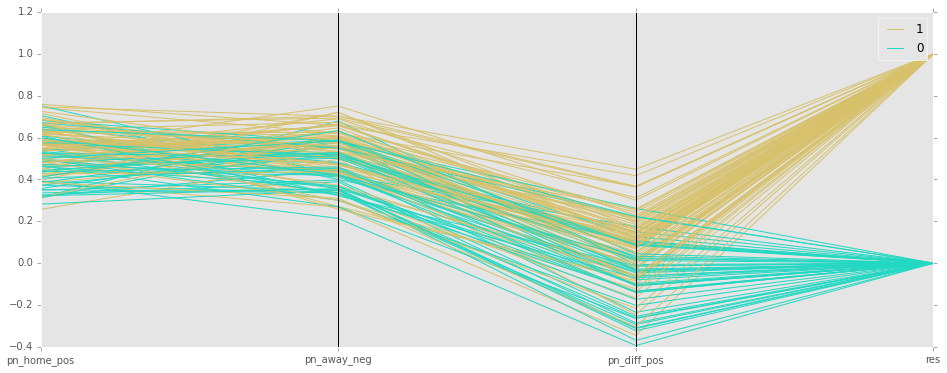

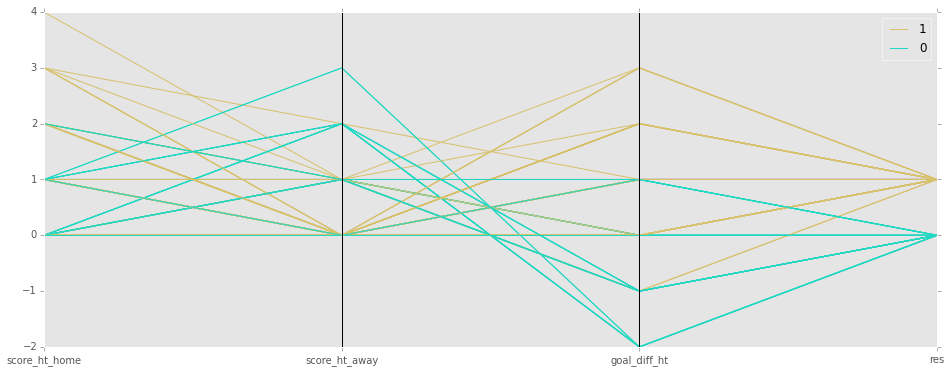

In [240]:
from pandas.tools.plotting import parallel_coordinates

df = CreateDfForModel(ft_wld=False)

df['res'] = df.result

data = df[[
        'pn_home_pos',
        'pn_away_neg',
        'pn_diff_pos',
        'res'
          ] + ['result']]
# data = df[df.columns[2:]]

plt.figure(figsize=(16, 6))
parallel_coordinates(data, 'result')



data = df[[
        'score_ht_home',
        'score_ht_away',
        'goal_diff_ht',
        'res'
          ] + ['result']]
plt.figure(figsize=(16, 6))
parallel_coordinates(data, 'result')

## Lag Plot

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


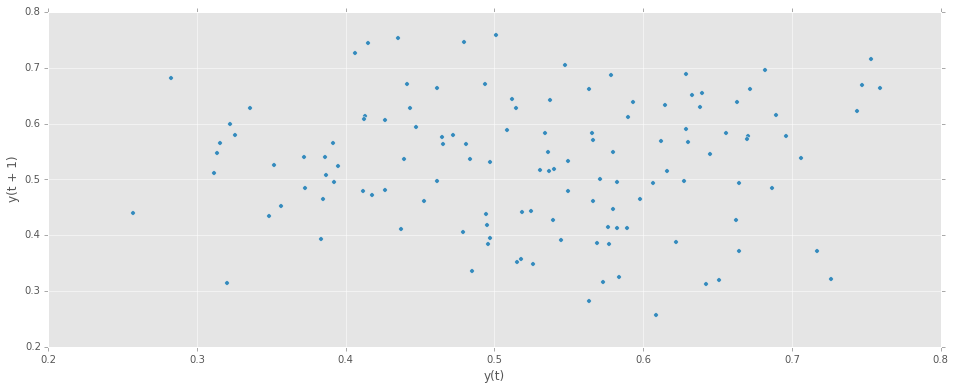

In [213]:
from pandas.tools.plotting import lag_plot

df = CreateDfForModel(ft_wld=False)
data = df.pn_home_pos

plt.figure(figsize=(16, 6))
lag_plot(data)

## Autocorrelation Plot

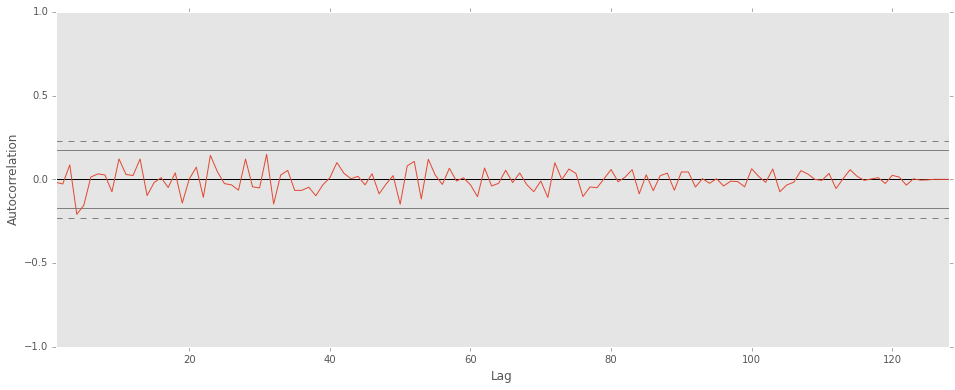

In [215]:
from pandas.tools.plotting import autocorrelation_plot

df = CreateDfForModel(ft_wld=False)
data = df.pn_diff_pos

plt.figure(figsize=(16, 6))
autocorrelation_plot(data)

## Bootstrap Plot

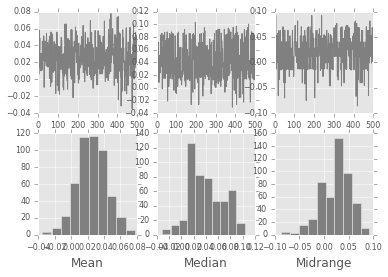

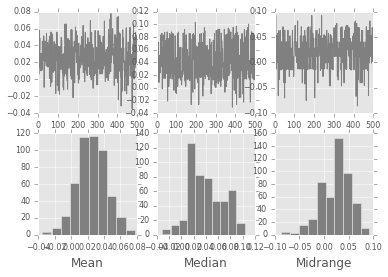

In [218]:
from pandas.tools.plotting import bootstrap_plot

df = CreateDfForModel(ft_wld=False)
data = df.pn_diff_pos

bootstrap_plot(data, size=50, samples=500, color='grey')

## RadViz

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


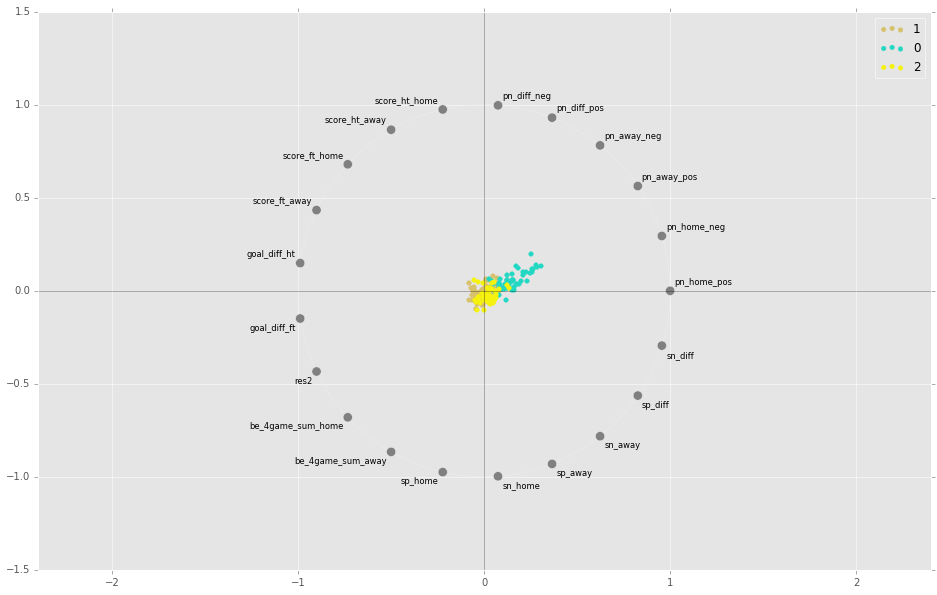

In [236]:
from pandas.tools.plotting import radviz


df = CreateDfForModel(ft_wld=True)

data = df[[
        'pn_diff_pos', 'score_ht_home', 
        'pn_diff_neg',
        'score_ht_away'
          ] + ['result']]
data = df[df.columns[2:]]

plt.figure(figsize=(16, 10))

radviz(data, 'result')
plt.axhline(y=0, c="k", alpha=0.3)
plt.axvline(x=0, c="k", alpha=0.3)